In [2]:
import requests
import io
import datetime

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [3]:
import statsmodels.api as sm

def correlation_plot(data):
    fig = plt.figure(figsize=(10, 8))
    # 自己相関のコレログラム
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_ylim(-1.1, 1.1)
    fig = sm.graphics.tsa.plot_acf(data, lags=60, ax=ax1)
    # 偏自己相関のコレログラム
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.set_ylim(-1.1, 1.1)    
    fig = sm.graphics.tsa.plot_pacf(data, lags=60, ax=ax2)
    plt.show()

In [4]:
# https://www.tepco.co.jp/forecast/html/download-j.html
# https://www.tepco.co.jp/forecast/html/images/juyo-{year}.csv

YEARS = [2016, 2017, 2018, 2019, 2020, 2021]

INPUT_DIR = "input/"

In [7]:
df = pd.read_csv(INPUT_DIR + 'daily.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [8]:
df.describe()

,power,power_std
count,1736.000000,1736.000000
mean,32.379022,4.715027
std,4.284944,1.715968
min,22.017917,1.543815
25%,29.499792,3.491317
50%,31.693750,4.489117
75%,35.410417,5.530723
max,44.855417,11.097150


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1736 entries, 2016-04-01 to 2020-12-31
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   power      1736 non-null   float64
 1   power_std  1736 non-null   float64
dtypes: float64(2)
memory usage: 40.7 KB


In [10]:
df.head()

,power,power_std
date,,
2016-04-01,29.844167,3.890796
2016-04-02,29.074167,3.279035
2016-04-03,26.582500,2.745138
2016-04-04,29.562083,4.809870
2016-04-05,31.905000,5.068970


In [11]:
df.tail()

,power,power_std
date,,
2020-12-27,31.65125,3.035334
2020-12-28,32.92250,4.672986
2020-12-29,31.52125,3.481043
2020-12-30,30.36875,3.865017
2020-12-31,31.69375,3.689998


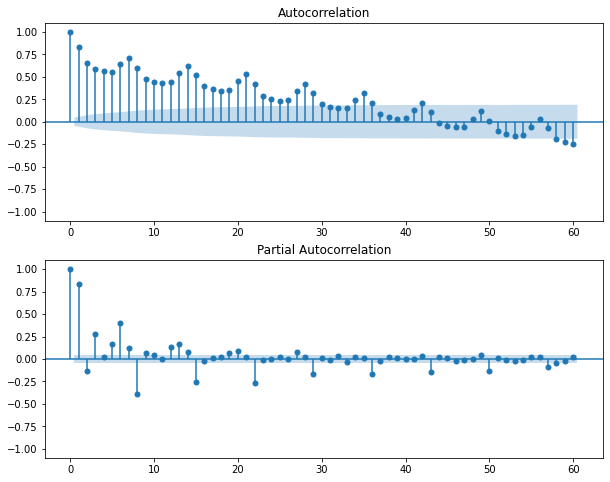

In [12]:
correlation_plot(df['power'])

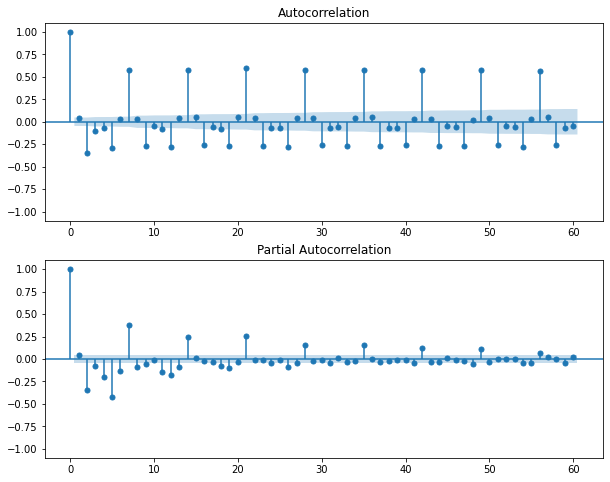

In [13]:
correlation_plot(df['power'].diff().dropna())

In [36]:
from statsmodels.tsa import stattools

In [74]:
y = df['power']

checks = ['ctt', 'ct', 'c', 'nc']
for c in checks:
    print(f'---{c}---')
    print(stattools.adfuller(y, regression=c))

---ctt---
(-5.188965447756165, 0.00047856717256513536, 21, 1714, {'1%': -4.37790316896518, '5%': -3.835839840904713, '10%': -3.555396936833689}, 6657.401272297892)
---ct---
(-5.139009607378648, 0.00011400233674434475, 21, 1714, {'1%': -3.9640615585936287, '5%': -3.4130545783684703, '10%': -3.128559858566482}, 6655.931956073176)
---c---
(-5.129607059475002, 1.2219314391918428e-05, 21, 1714, {'1%': -3.4341709571201133, '5%': -2.86322773854977, '10%': -2.5676685057505693}, 6654.106600857504)
---nc---
(-0.41000173079732144, 0.532704591416506, 21, 1714, {'1%': -2.567045668671344, '5%': -1.9411578486673504, '10%': -1.616665959624789}, 6678.502575973545)


In [75]:
dy = df['power'].diff().dropna()

checks = ['ctt', 'ct', 'c', 'nc']
for c in checks:
    print(f'--diff-{c}---')
    print(stattools.adfuller(y, regression=c))

--diff-ctt---
(-5.188965447756165, 0.00047856717256513536, 21, 1714, {'1%': -4.37790316896518, '5%': -3.835839840904713, '10%': -3.555396936833689}, 6657.401272297892)
--diff-ct---
(-5.139009607378648, 0.00011400233674434475, 21, 1714, {'1%': -3.9640615585936287, '5%': -3.4130545783684703, '10%': -3.128559858566482}, 6655.931956073176)
--diff-c---
(-5.129607059475002, 1.2219314391918428e-05, 21, 1714, {'1%': -3.4341709571201133, '5%': -2.86322773854977, '10%': -2.5676685057505693}, 6654.106600857504)
--diff-nc---
(-0.41000173079732144, 0.532704591416506, 21, 1714, {'1%': -2.567045668671344, '5%': -1.9411578486673504, '10%': -1.616665959624789}, 6678.502575973545)


In [39]:
import statsmodels.api as sm

In [92]:
yw = y.resample("W").mean()
yw.head(7)

DATE
2016-04-03    28.500278
2016-04-10    29.249286
2016-04-17    29.392024
2016-04-24    28.636488
2016-05-01    28.005298
2016-05-08    25.686905
2016-05-15    29.140714
Freq: W-SUN, Name: power, dtype: float64

/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


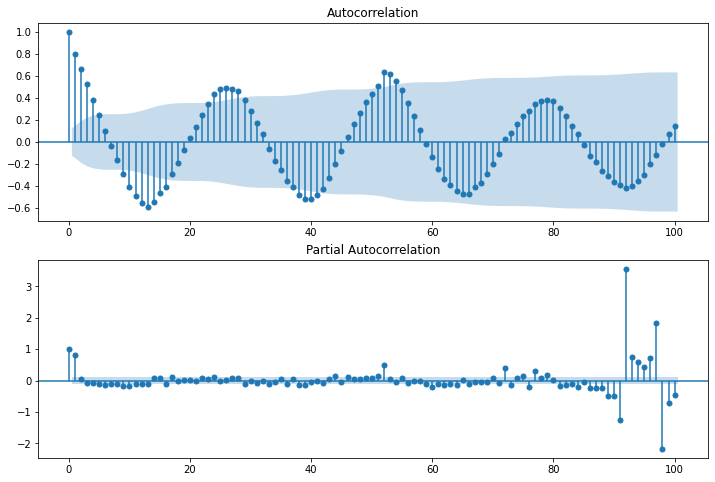

In [93]:
fig,ax = plt.subplots(2,1,figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(yw, lags=100, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(yw, lags=100, ax=ax[1])
plt.show()

<AxesSubplot:xlabel='DATE'>

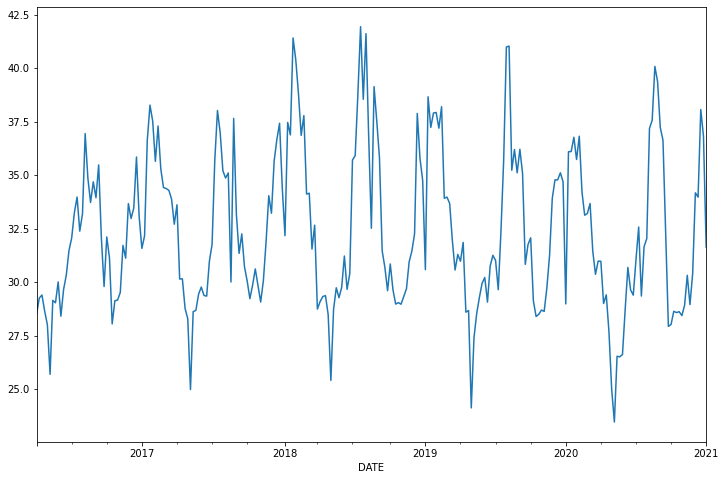

In [94]:
yw.plot()

<AxesSubplot:xlabel='DATE'>

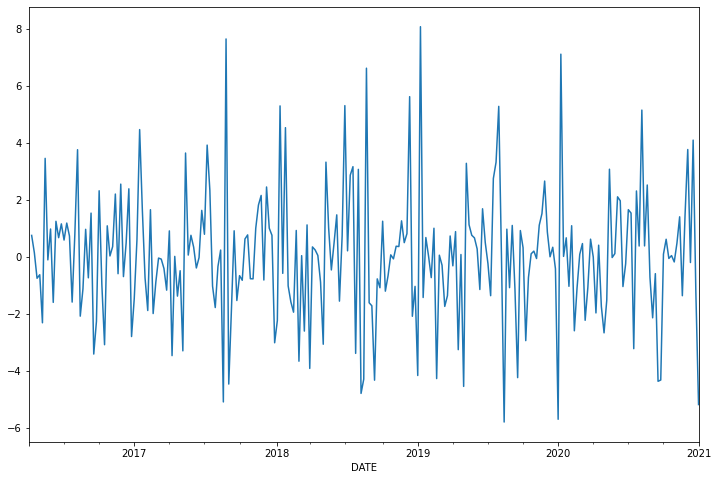

In [95]:
yw.diff().plot()

In [96]:
results = sm.tsa.stattools.adfuller(y)
print('ADF Statistic: %f' % results[0])
print('P-Value: %f' % results[1])

ADF Statistic: -5.129607
P-Value: 0.000012


In [97]:
yw

DATE
2016-04-03    28.500278
2016-04-10    29.249286
2016-04-17    29.392024
2016-04-24    28.636488
2016-05-01    28.005298
                ...    
2020-12-06    34.168571
2020-12-13    33.966071
2020-12-20    38.060060
2020-12-27    36.815298
2021-01-03    31.626562
Freq: W-SUN, Name: power, Length: 249, dtype: float64

Text(0, 0.5, 'Residual')

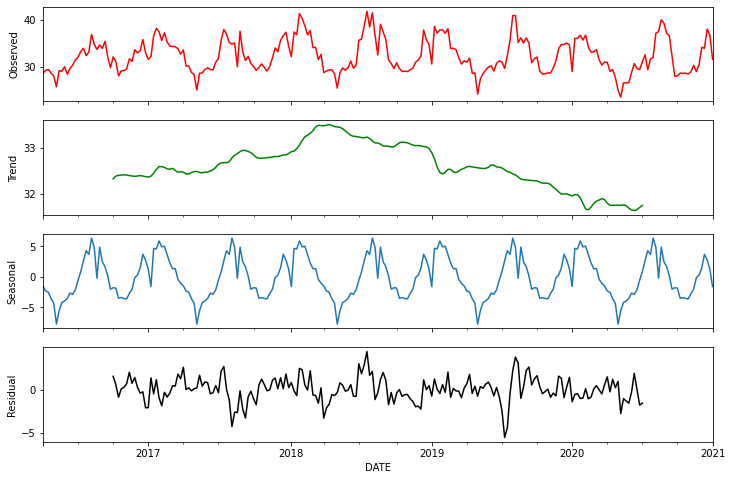

In [98]:
fig, axes = plt.subplots(4, 1, sharex=True)

decomposition = sm.tsa.seasonal_decompose(yw, model ='additive')
decomposition.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')

In [99]:
# 考えられるパラメータの組み合わせを全て作成
max_p = 2
max_d = 1
max_q = 1
max_sp = 1
max_sd = 1
max_sq = 1
params = []

for p in range(0, max_p + 1):
    for d in range(0, max_d + 1): 
        for q in range(0, max_q + 1): 
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1): 
                    for sq in range(0, max_sq + 1): 
                        params.append([p,d,q,sp,sd,sq])

params[:3]

[[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0]]

In [100]:
# テストするため, 学習用とテスト用データの分割

num = len(yw)
n_test = 52

y_train, y_test = yw.head(num - n_test), yw.tail(n_test)

# AIC計算用のメソッドを作成
def aic_calculater(param):
    aic = sm.tsa.statespace.SARIMAX(
                                endog=y_train, trend="n", freq='W', order=(param[0], param[1], param[2]),
                                seasonal_order=(param[3], param[4], param[5], 52), enforce_invertibility = False, enforce_stationarity = False).fit().aic
    return aic
 
# 並列計算: n_jobs=-1とするとCPUコア数の数だけ並列化される
import joblib
aic_list = joblib.Parallel(n_jobs=-1, verbose=10)([joblib.delayed(aic_calculater)(param) for param in params])
 
# AICが小さくなる順にのパラメータの組み合わせを並べ変え
aic_df = pd.DataFrame({"params": params, "aic": aic_list})
aic_df.sort_values("aic", inplace=True)
aic_df.head(10)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  91 out of  96 | elapsed:   18.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   23.6s finished


,params,aic
59,"[1, 1, 1, 0, 1, 1]",369.841861
43,"[1, 0, 1, 0, 1, 1]",371.155896
91,"[2, 1, 1, 0, 1, 1]",371.841859
35,"[1, 0, 0, 0, 1, 1]",372.029343
75,"[2, 0, 1, 0, 1, 1]",373.066754
67,"[2, 0, 0, 0, 1, 1]",374.029268
11,"[0, 0, 1, 0, 1, 1]",378.421633
71,"[2, 0, 0, 1, 1, 1]",380.623574
47,"[1, 0, 1, 1, 1, 1]",380.685641
63,"[1, 1, 1, 1, 1, 1]",381.433517


In [101]:
y_test

DATE
2020-01-12    36.087024
2020-01-19    36.099167
2020-01-26    36.763512
2020-02-02    35.725714
2020-02-09    36.814762
2020-02-16    34.215417
2020-02-23    33.121488
2020-03-01    33.206548
2020-03-08    33.669286
2020-03-15    31.438155
2020-03-22    30.360714
2020-03-29    30.977798
2020-04-05    30.968393
2020-04-12    28.996190
2020-04-19    29.401726
2020-04-26    27.659583
2020-05-03    24.987917
2020-05-10    23.457738
2020-05-17    26.530298
2020-05-24    26.502738
2020-05-31    26.612262
2020-06-07    28.715774
2020-06-14    30.681548
2020-06-21    29.635238
2020-06-28    29.386548
2020-07-05    31.038869
2020-07-12    32.571250
2020-07-19    29.344286
2020-07-26    31.653333
2020-08-02    32.029762
2020-08-09    37.178155
2020-08-16    37.558333
2020-08-23    40.076786
2020-08-30    39.365000
2020-09-06    37.221190
2020-09-13    36.627619
2020-09-20    32.255476
2020-09-27    27.928274
2020-10-04    28.018333
2020-10-11    28.632262
2020-10-18    28.572798
2020-10-25 

In [102]:
# AICが最小のパラメータを当てはめる
model = sm.tsa.statespace.SARIMAX(
                                endog=y_train, trend="n", freq='W', order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 52),  enforce_invertibility = False, enforce_stationarity = False)

results = model.fit()

# テスト期間の予測値を出力する
y_pred = results.get_prediction(
                                start = y_test.index[0],
                                end = y_test.index[-1],
                                dynamic=False)
 
# 点推定での予測値と区間推定での予測値を取り出す
pred_mean = y_pred.predicted_mean
pred_ci = y_pred.conf_int(alpha = .05)

# MAPEを計算する自作関数を定義
def mape(true, pred):
    
    act = list(true)
    preds = list(pred)
    total = 0
    for i in range(len(act)):
        ape = np.abs((act[i] - preds[i])/act[i])
        total += ape
    mape = (total / len(act)) * 100
    
    return mape

# MAPEを算出
print(mape(y_test, pred_mean))


/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


6.536161713287745


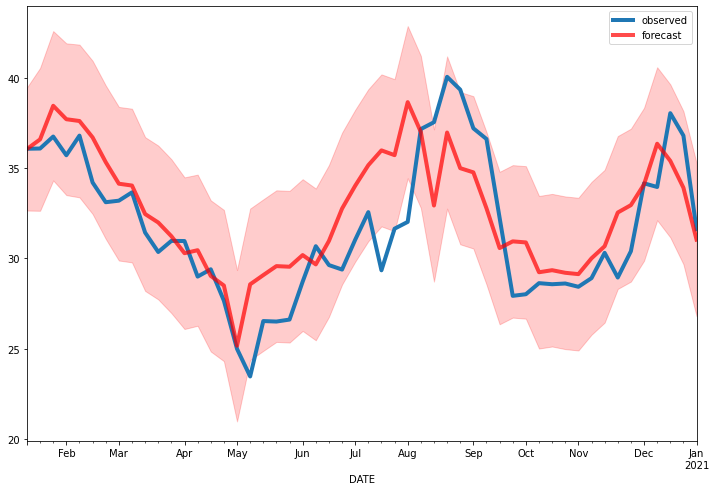

In [103]:
y_test.plot(label='observed', linewidth=4)
pred_mean.plot(label='forecast', alpha=.7, color = "r", linewidth=4)
 
# 区間予測の折れ線グラフを描画
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='r', alpha=.2)
plt.legend()
plt.show()

In [88]:
plot = results.plot_diagnostics()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 864x576 with 0 Axes>